In [192]:
from pprint import pprint
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils import data

import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import trange

> 강의이후 라이브러리 사용중 막히는 것이 있을때는,  
Pytorch Official Documentation: https://pytorch.org/docs/stable/index.html  
을 참고하시는 것을 권장드립니다

In [193]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [194]:
EPOCHS = 20
BATCH_SIZE = 64

In [195]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [196]:
trainset = datasets.FashionMNIST(
    root      = './data/', 
    train     = True,
    download  = True,
    transform = transform
)

testset = datasets.FashionMNIST(
    root      = './data/', 
    train     = False,
    download  = True,
    transform = transform
)

In [197]:
train_loader = data.DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = data.DataLoader(dataset=testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [198]:
dataiterator = iter(train_loader)
images, labels = next(dataiterator)

In [199]:
images.shape

torch.Size([64, 1, 28, 28])

In [200]:
labels

tensor([1, 5, 6, 1, 7, 1, 4, 7, 6, 0, 9, 5, 0, 3, 3, 9, 0, 7, 0, 1, 3, 1, 0, 0,
        3, 9, 6, 6, 4, 5, 8, 6, 2, 7, 8, 6, 4, 2, 3, 5, 3, 3, 2, 1, 0, 3, 2, 7,
        5, 2, 9, 9, 6, 3, 4, 8, 3, 6, 0, 4, 7, 4, 8, 5])

torch.Size([3, 224, 224])
torch.Size([224, 224, 3])


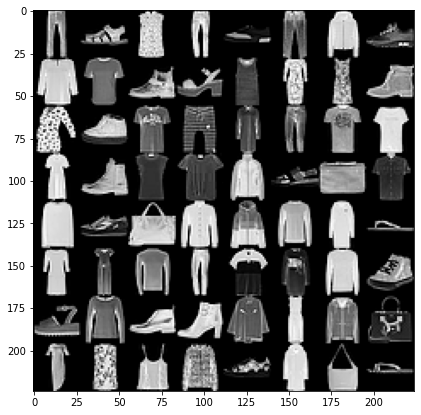

In [201]:
img   = utils.make_grid(images, padding=0)
# 자동으로 RGB로 바뀜
print(img.shape)
# matplotlib은 이미지를 가로x세로x채널로 받으므로 차원을 한칸씩 밀어준다
img = img.permute((1,2,0))
print(img.shape)
plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.show()

In [202]:
CLASSES = {v: k for k, v in trainset.class_to_idx.items()}
pprint(CLASSES)

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}


In [203]:
for i, label in enumerate(labels):
    index = label.item()
    print("{:12}".format(CLASSES[index]), end=' ')
    if i % 8 == 7:
        print()

Trouser      Sandal       Shirt        Trouser      Sneaker      Trouser      Coat         Sneaker      
Shirt        T-shirt/top  Ankle boot   Sandal       T-shirt/top  Dress        Dress        Ankle boot   
T-shirt/top  Sneaker      T-shirt/top  Trouser      Dress        Trouser      T-shirt/top  T-shirt/top  
Dress        Ankle boot   Shirt        Shirt        Coat         Sandal       Bag          Shirt        
Pullover     Sneaker      Bag          Shirt        Coat         Pullover     Dress        Sandal       
Dress        Dress        Pullover     Trouser      T-shirt/top  Dress        Pullover     Sneaker      
Sandal       Pullover     Ankle boot   Ankle boot   Shirt        Dress        Coat         Bag          
Dress        Shirt        T-shirt/top  Coat         Sneaker      Coat         Bag          Sandal       


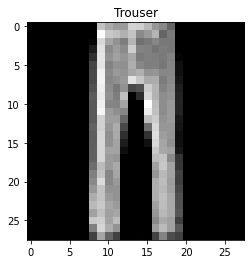

In [204]:
idx = 0
item_img = images[idx]
item_npimg = item_img.squeeze().numpy()
plt.title(CLASSES[labels[idx].item()])
plt.imshow(item_npimg, cmap='gray')
plt.show()

## 아래 함수를 완성해보세요.
### *활용이 가능하신 분은 Baseline으로 제시된 성능 보다 더 나은 성능을 내보세요.*

In [205]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [206]:
model = Net().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma = 0.1)

In [207]:
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

In [208]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()
            pred = output.max(dim=1)[1]
            correct += pred.eq(target).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
test_loss, test_accuracy = evaluate(model, test_loader)
print(f'[{0:3}] Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f} %')
for epoch in trange(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print(f'[{epoch:3}] Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f} %')

In [ ]:
columns = 6
rows = 6
fig = plt.figure(figsize=(10,10))
 
model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(testset))
    input_img = testset[data_idx][0].unsqueeze(dim=0).to(DEVICE) 
    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = CLASSES[argmax.item()]
    label = CLASSES[testset[data_idx][1]]
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(label+'/'+pred)
        cmap = 'Blues'
    else:
        plt.title(label+'/'+pred)
        cmap = 'Reds'
    plot_img = testset[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')
    
plt.show() 

## MNIST dataset에 대해서도 적용해봅시다!

In [210]:
trainset = datasets.MNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transform
)

testset = datasets.MNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transform
)

In [211]:
CLASSES = {v: k.split(' - ')[1] for k, v in trainset.class_to_idx.items()}
pprint(CLASSES)

{0: 'zero',
 1: 'one',
 2: 'two',
 3: 'three',
 4: 'four',
 5: 'five',
 6: 'six',
 7: 'seven',
 8: 'eight',
 9: 'nine'}


## train 코드 작성

In [212]:
"""
데이터 로더 생성
모델 생성
optimizer, lr scheduler 생성
정해진 epoch 만큼 train 반복
"""

'\n데이터 로더 생성\n모델 생성\noptimizer, lr scheduler 생성\n정해진 epoch 만큼 train 반복\n'

In [213]:
train_loader = data.DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = data.DataLoader(dataset=testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [214]:
model = Net().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma = 0.1)

In [215]:
test_loss, test_accuracy = evaluate(model, test_loader)
print(f'[{0:3}] Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f} %')
for epoch in trange(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print(f'[{epoch:3}] Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f} %')

[  0] Test Loss: 2.3062, Accuracy: 11.40 %


  0%|          | 0/20 [00:00<?, ?it/s]

[  1] Test Loss: 0.7346, Accuracy: 82.96 %
[  2] Test Loss: 0.4095, Accuracy: 88.56 %
[  3] Test Loss: 0.3447, Accuracy: 90.02 %
[  4] Test Loss: 0.3080, Accuracy: 91.18 %
[  5] Test Loss: 0.2852, Accuracy: 91.90 %
[  6] Test Loss: 0.2671, Accuracy: 92.35 %
[  7] Test Loss: 0.2513, Accuracy: 93.06 %
[  8] Test Loss: 0.2369, Accuracy: 93.33 %
[  9] Test Loss: 0.2217, Accuracy: 93.73 %
[ 10] Test Loss: 0.2113, Accuracy: 93.98 %
[ 11] Test Loss: 0.2007, Accuracy: 94.26 %
[ 12] Test Loss: 0.1934, Accuracy: 94.30 %
[ 13] Test Loss: 0.1827, Accuracy: 94.52 %
[ 14] Test Loss: 0.1735, Accuracy: 95.00 %
[ 15] Test Loss: 0.1676, Accuracy: 95.03 %
[ 16] Test Loss: 0.1607, Accuracy: 95.24 %
[ 17] Test Loss: 0.1608, Accuracy: 95.10 %
[ 18] Test Loss: 0.1490, Accuracy: 95.67 %
[ 19] Test Loss: 0.1412, Accuracy: 95.72 %
[ 20] Test Loss: 0.1399, Accuracy: 95.79 %


## 학습결과 평가

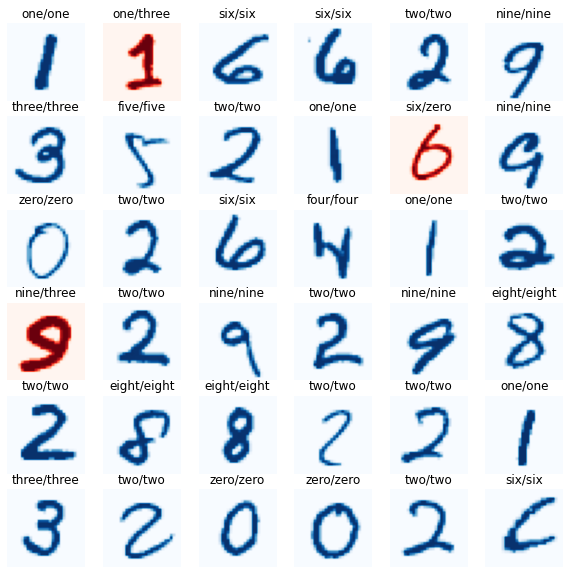

In [216]:
columns = 6
rows = 6
fig = plt.figure(figsize=(10,10))
 
model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(testset))
    input_img = testset[data_idx][0].unsqueeze(dim=0).to(DEVICE) 
    
    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = CLASSES[argmax.item()]
    label = CLASSES[testset[data_idx][1]]
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(label+'/'+pred)
        cmap = 'Blues'
    else:
        plt.title(label+'/'+pred)
        cmap = 'Reds'
    plot_img = testset[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')
    
plt.show() 